In [1]:
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os, numpy as np
from scipy.stats import skew, kurtosis, entropy
from tqdm import tqdm
from sklearn.mixture import GaussianMixture as gmm
import networkx.algorithms.community as nx_comm
from itertools import product
import matplotlib.patches as mpatches

In [2]:
sns.set_style({'axes.facecolor': 'white',
         'axes.edgecolor': 'black',
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor':"white",
        'axes.labelcolor': '.15',
         'grid.color': 'white',
         'grid.linestyle': '-',
         'text.color': '.15',
         'xtick.color': '.15',
         'ytick.color': '.15',
        'patch.edgecolor': 'white',})

In [98]:
TAR_DIR = "/N/slate/harryan/sim_data_extra/"
os.mkdir(TAR_DIR+"opinions_init")

In [4]:
ROOT_DIR = "/N/slate/harryan/sim_data/"

In [102]:
Ns = ["N"+str(i) for i in range(6)]
op_folders = []
for n in Ns:
    n_f = ROOT_DIR+f"{n}/"
    folders = os.listdir(n_f)
    for f in folders:
        op_folders.append(f"{n}/{f}/opinions/")

In [103]:
op_folders[0:10]

['N0/s0eta8/opinions/',
 'N0/s0eta2/opinions/',
 'N0/s0eta5/opinions/',
 'N1/s7eta8/opinions/',
 'N1/s1eta8/opinions/',
 'N1/s3eta5/opinions/',
 'N1/s5eta2/opinions/',
 'N1/s3eta8/opinions/',
 'N1/s1eta5/opinions/',
 'N1/s1eta2/opinions/']

In [5]:
Ns = ["N"+str(i) for i in range(6)]
#etas = ["s"+ str(i) for i in [2, 5, 8]]
#ss = [str(i) for i in [1, 3, 5, 7, 9]]
op_folders = []
for n in Ns:
    n_f = ROOT_DIR+f"{n}/"
    folders = os.listdir(n_f)
    for f in folders:
        op_folders.append(f"{n}/{f}/opinions/")

In [6]:
#ROOT_DIR+f"N0/s{str(s)}eta{str(eta)}/opinions/"
def get_raw_final_op(folder):
    PATHs = ROOT_DIR + folder
    files = os.listdir(PATHs)
    data =[]
    new_col = []
    for f in tqdm(files, desc = folder):
        new_col.append(f.split("_")[0])
        df = pd.read_parquet(PATHs + f)
        data.append(df[df.columns[-1]])
    res = pd.concat(data, axis = 1)
    res.columns = new_col
    new_file_name = folder.replace("/","_")[:-1] + ".parquet"
    res.to_parquet(TAR_DIR+"Opinions/" + new_file_name) 
        

In [7]:
def BC(data):
    """Calculate the bimodality coefficient of a distribution.
    
    Args:
        data (numpy.ndarray): The data to analyze.
    
    Returns:
        The bimodality coefficient of the distribution.
    """
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Calculate the bimodality coefficient
    b = (skewness**2 + 1) / (kurt + 3)
    
    return b


In [8]:
def entropy_continuous(x, nbins=100):
    # Define bins
    bins = np.linspace(-1, 1, nbins+1)
    
    # Bin the data
    counts, _ = np.histogram(x, bins)
    
    # Compute proportions
    props = counts / np.sum(counts)
    
    # Compute entropies
    eps = np.finfo(float).eps # small number to avoid log(0)
    entropies = -props * np.log2(props+eps)
    
    # Compute total entropy
    entropy = np.sum(entropies)
    
    return entropy

In [9]:
def gini_continuous(x):
    # Shift x to be positive
    x_shifted = x - np.min(x) +.01
    # Calculate the sample size
    n = len(x)
    # Sort x in ascending order and calculate the rank
    rank = np.argsort(np.argsort(x))
    # Calculate the Gini coefficient
    G = (2 / n**2 * (n + 1 - 2 * np.sum(rank * x_shifted))) * np.sum(np.abs(x_shifted))
    return G

In [10]:
OP_DIR = "/N/slate/harryan/sim_data_extra/opinions"

In [11]:
measures = {}
op_files = os.listdir(OP_DIR)
for f in tqdm(op_files):
    df = pd.read_parquet(OP_DIR+f"/{f}")
    measures[tuple(f.split("_")[:2])] = {"entropy": df.apply(entropy_continuous, axis = 0) , "BC": df.apply(BC, axis = 0)}

100%|██████████| 78/78 [00:21<00:00,  3.68it/s]


In [12]:
entropies = pd.concat([ pd.DataFrame(v).entropy for v in measures.values()], axis = 1, ignore_index= True)
entropies.columns = measures.keys()
entropies.index = range(100)

bimode_coeff = pd.concat([ pd.DataFrame(v).BC for v in measures.values()], axis = 1, ignore_index=True)
bimode_coeff.columns = measures.keys()
bimode_coeff.index = range(100)


In [13]:
entropies = entropies.T.reset_index()
entropies["N"] = entropies.level_0.apply(lambda x: int(x[-1]))
entropies["s"] = entropies.level_1.apply(lambda x: int(x[1]))
entropies["eta"] = entropies.level_1.apply(lambda x: int(x[-1]))

In [14]:
bimode_coeff = bimode_coeff.T.reset_index()
bimode_coeff["N"] = bimode_coeff.level_0.apply(lambda x: int(x[-1]))
bimode_coeff["s"] = bimode_coeff.level_1.apply(lambda x: int(x[1]))
bimode_coeff["eta"] = bimode_coeff.level_1.apply(lambda x: int(x[-1]))

In [ ]:
base_eta2 = pd.read_parquet(OP_DIR+ '/N0_s0eta2_opinions.parquet')
base_eta5 = pd.read_parquet(OP_DIR+ '/N0_s0eta5_opinions.parquet')
base_eta8 = pd.read_parquet(OP_DIR+ '/N0_s0eta8_opinions.parquet')

In [121]:
base_final = [base_eta2 ,base_eta5, base_eta8]


Text(0.5, 1.05, 'Final Opinion of Baseline Models')

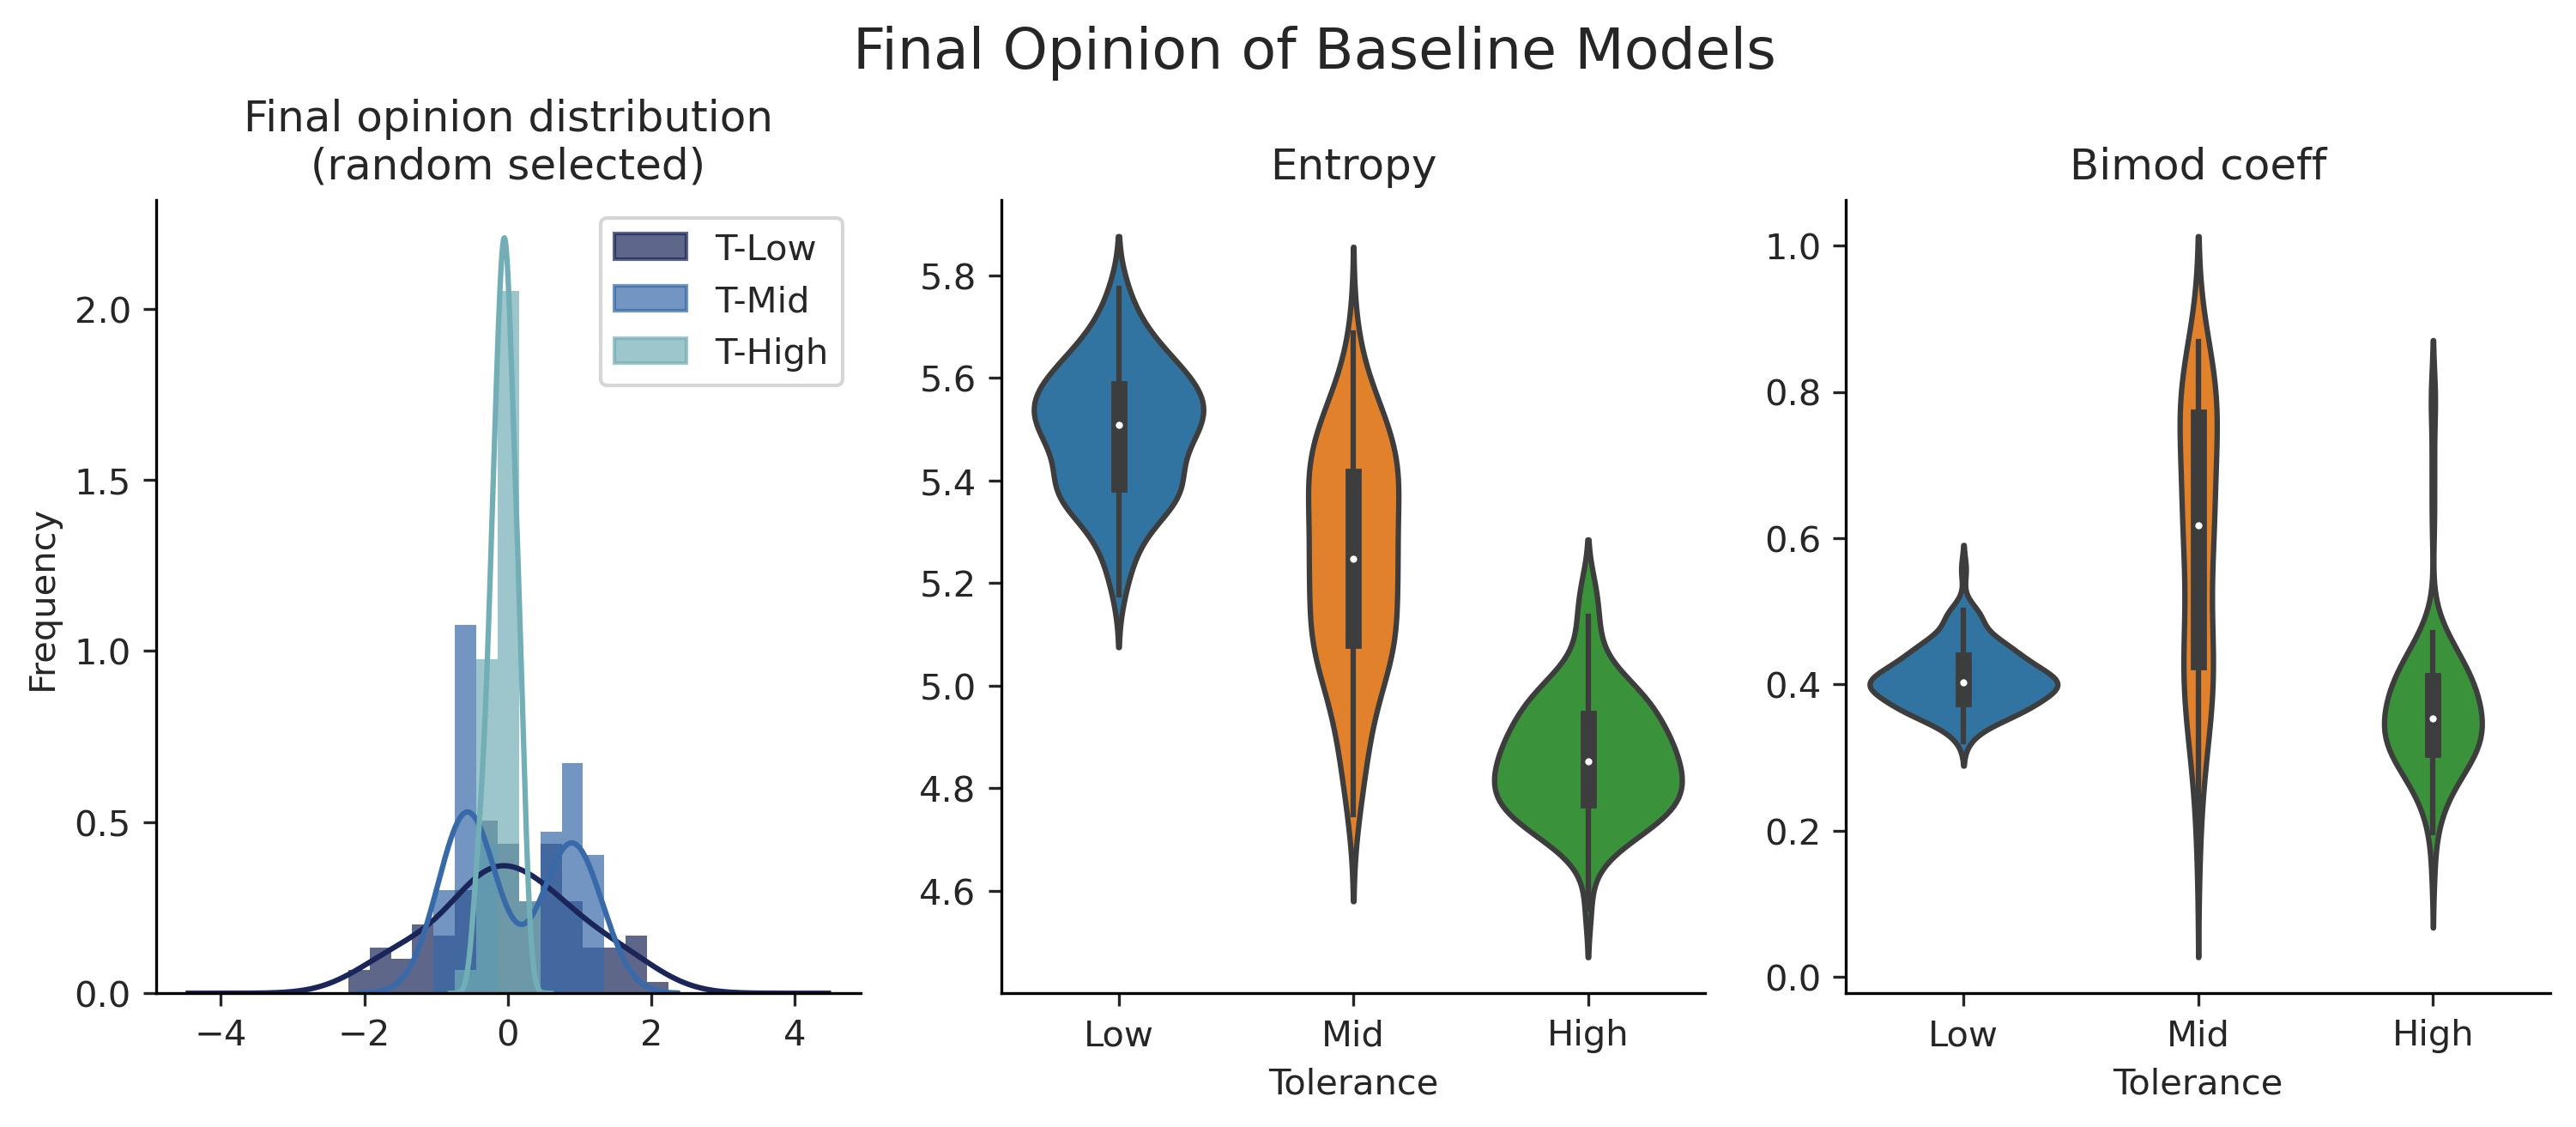

In [213]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi = 300)
bl_entropies= entropies[entropies.N==0][range(100)].T
bl_bimod_coeff = bimode_coeff[bimode_coeff.N==0][range(100)].T
random_base_final = pd.concat([i.sample(1, axis =1) for i in base_final], axis =1, ignore_index = True)
new_cols = ["Low", "Mid", "High",]
bl_entropies.columns = new_cols
bl_bimod_coeff.columns = new_cols
random_base_final.columns = new_cols
plot_data = [random_base_final, bl_entropies, bl_bimod_coeff]
titles = ["Final opinion distribution\n(random selected)", "Entropy", "Bimod coeff"]
colors = ["#1A2659", "#3869A8", "#72aeb6"]
for i, ax in enumerate(axes):
    if i == 0:
        plot_data[i].plot.kde(ax = ax, color = colors, bw_method=0.5)
        plot_data[i].plot.hist(alpha = .7, density = True, color = colors, ax = ax, bins = 15)
        ax.get_legend().remove()
    else:
        sns.violinplot(plot_data[i], ax = ax)
        ax.set_xlabel("Tolerance")
    #sns.histplot(plot_data[i], kde = True, ax = ax, bins = 15, color = ["#011959", "#3C6D56", "#D29343"])
    ax.set_title(titles[i])
l_patch = mpatches.Patch(color=colors[0], label='T-Low', alpha = .7)
m_patch = mpatches.Patch(color=colors[1], label='T-Mid', alpha = .7)
h_patch = mpatches.Patch(color=colors[2], label='T-High', alpha = .7)
axes[0].legend(handles=[l_patch, m_patch, h_patch])
    #if i ==1:
        #ax.get_legend().remove()
plt.suptitle("Final Opinion of Baseline Models", y = 1.05, fontsize = 16)

In [15]:
ave_ent = {}
     = [2, 5, 8]
for eta in etas:
    ave_ent_one = entropies[entropies.eta ==eta].groupby(["N", "s"])[list(range(100))].mean().mean(axis =1).reset_index()
    ave_ent[eta] =ave_ent_one.pivot (index = "N", columns = "s", values = 0)

In [16]:
ave_bc = bimode_coeff[bimode_coeff.eta ==2].groupby(["N", "s"])[list(range(100))].mean().mean(axis =1).reset_index()
ave_bc = ave_bc.pivot (index = "N", columns = "s", values = 0)

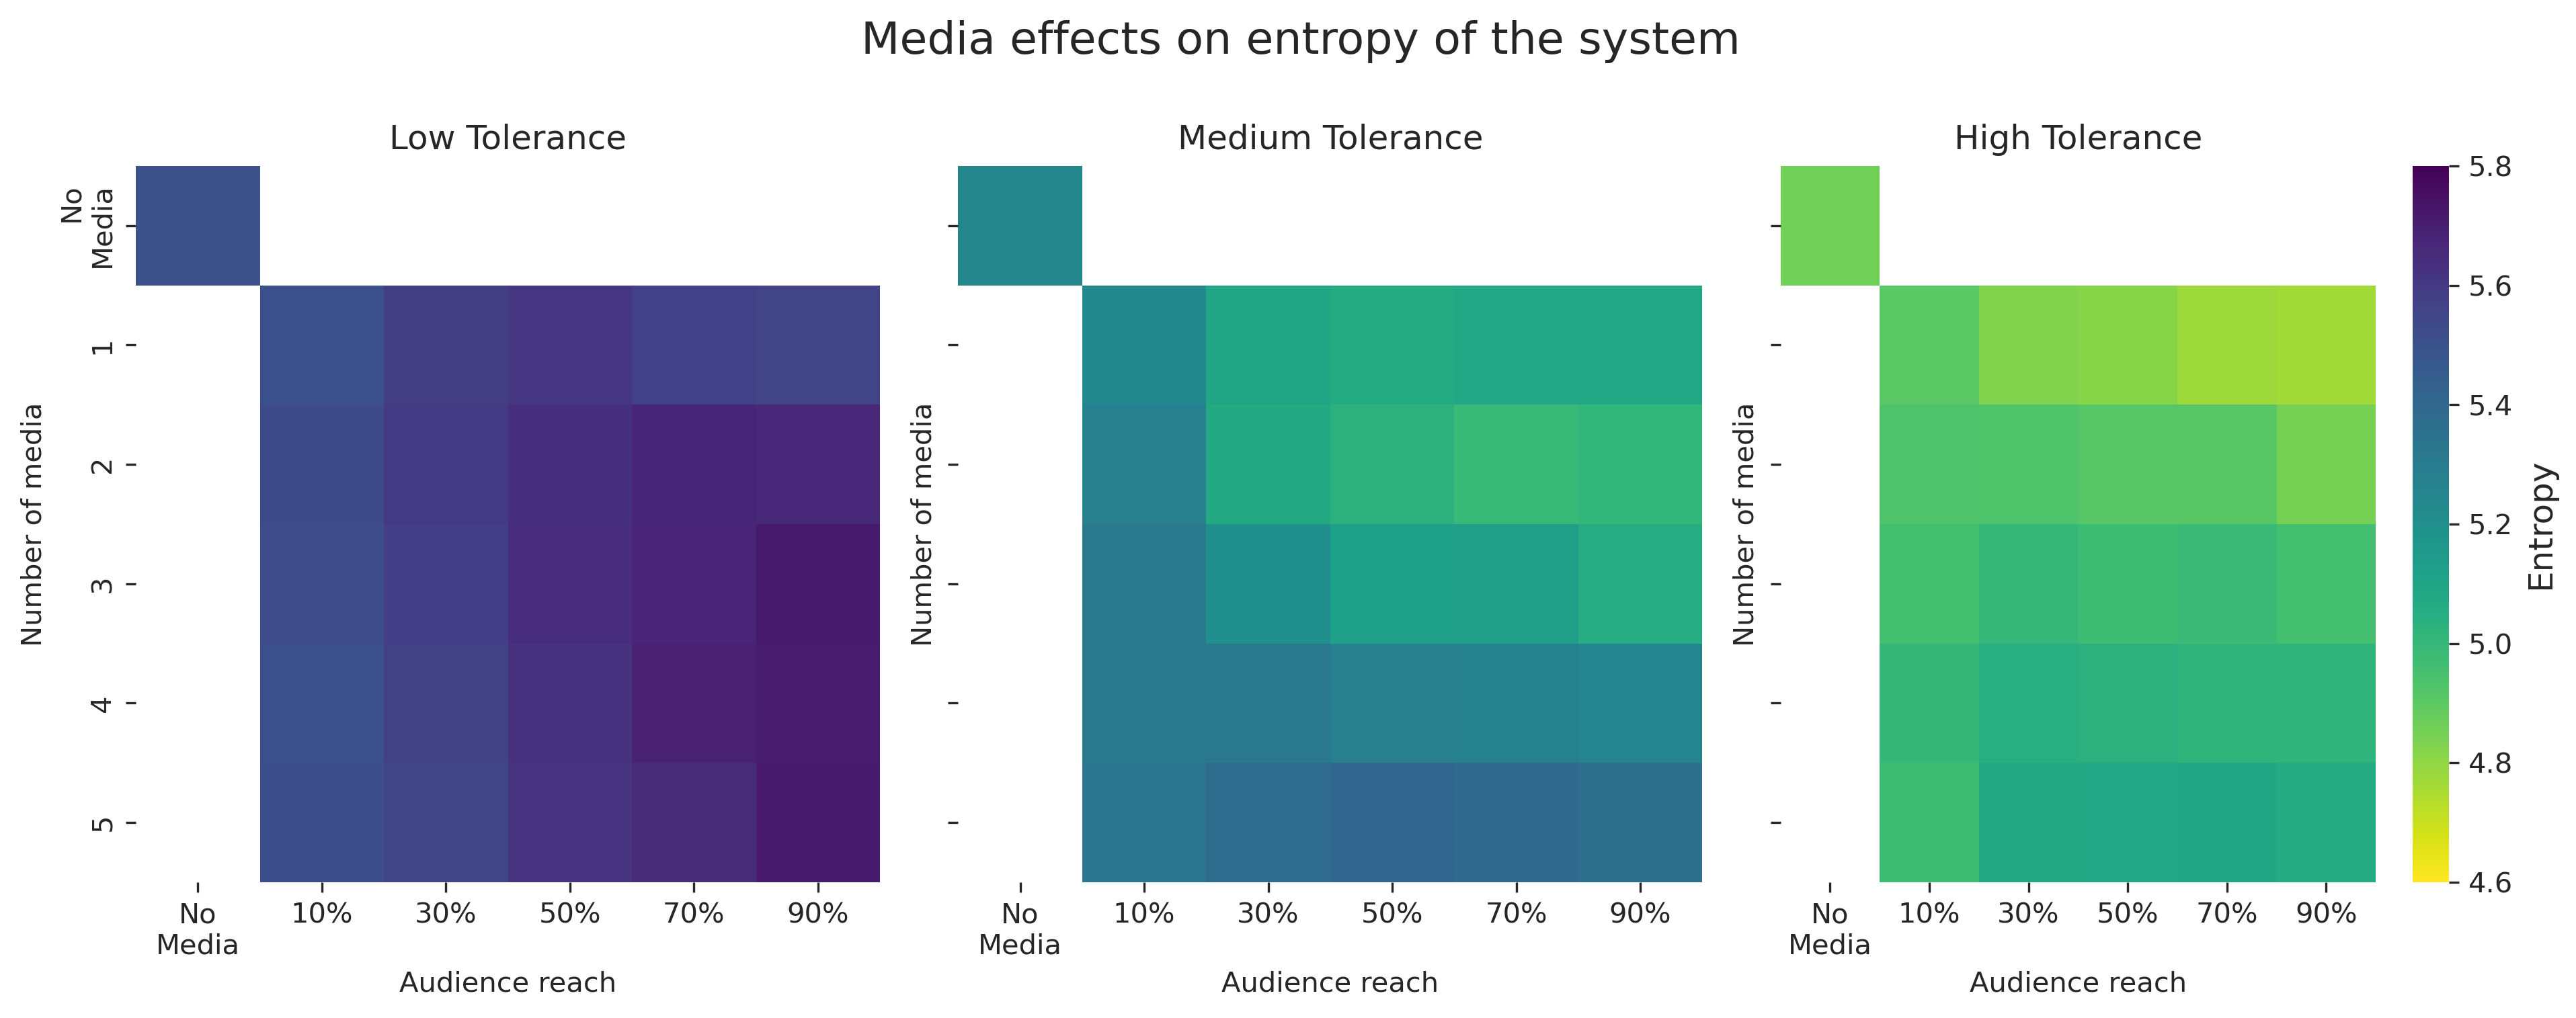

In [19]:
titles = ["Low Tolerance", "Medium Tolerance", "High Tolerance"]
fig, axes = plt.subplots(1, 3, figsize = (13,5), dpi = 300, sharey = True, sharex = True)
for i, ax in enumerate(axes):
    heatmap = sns.heatmap(ave_ent[etas[i]], ax = ax, cmap = "viridis_r", cbar_kws={"orientation": "vertical", "location": "right"}, vmin = 4.6, vmax = 5.8)
    cbar = heatmap.collections[0].colorbar
    if i !=2:
        cbar.remove()
    else:
        cbar.ax.set_ylabel("Entropy", fontsize = 12)
    ax.set_ylabel("Number of media")
    ax.set_xlabel("Audience reach")
    ax.set_title(titles[i])
    ax.set_xticklabels(["No\nMedia"]+[str(i*10) + "%" for i in [1,3,5,7,9 ]])
    ax.set_yticklabels(["No\nMedia"]+[1, 2, 3, 4, 5])

plt.suptitle("Media effects on entropy of the system", fontsize = 16, y = 1.0)
plt.tight_layout()

In [20]:
ave_bc = {}
for eta in etas:
    ave_bc_one = bimode_coeff[bimode_coeff.eta ==eta].groupby(["N", "s"])[list(range(100))].mean().mean(axis =1).reset_index()
    ave_bc[eta] =ave_bc_one.pivot (index = "N", columns = "s", values = 0)

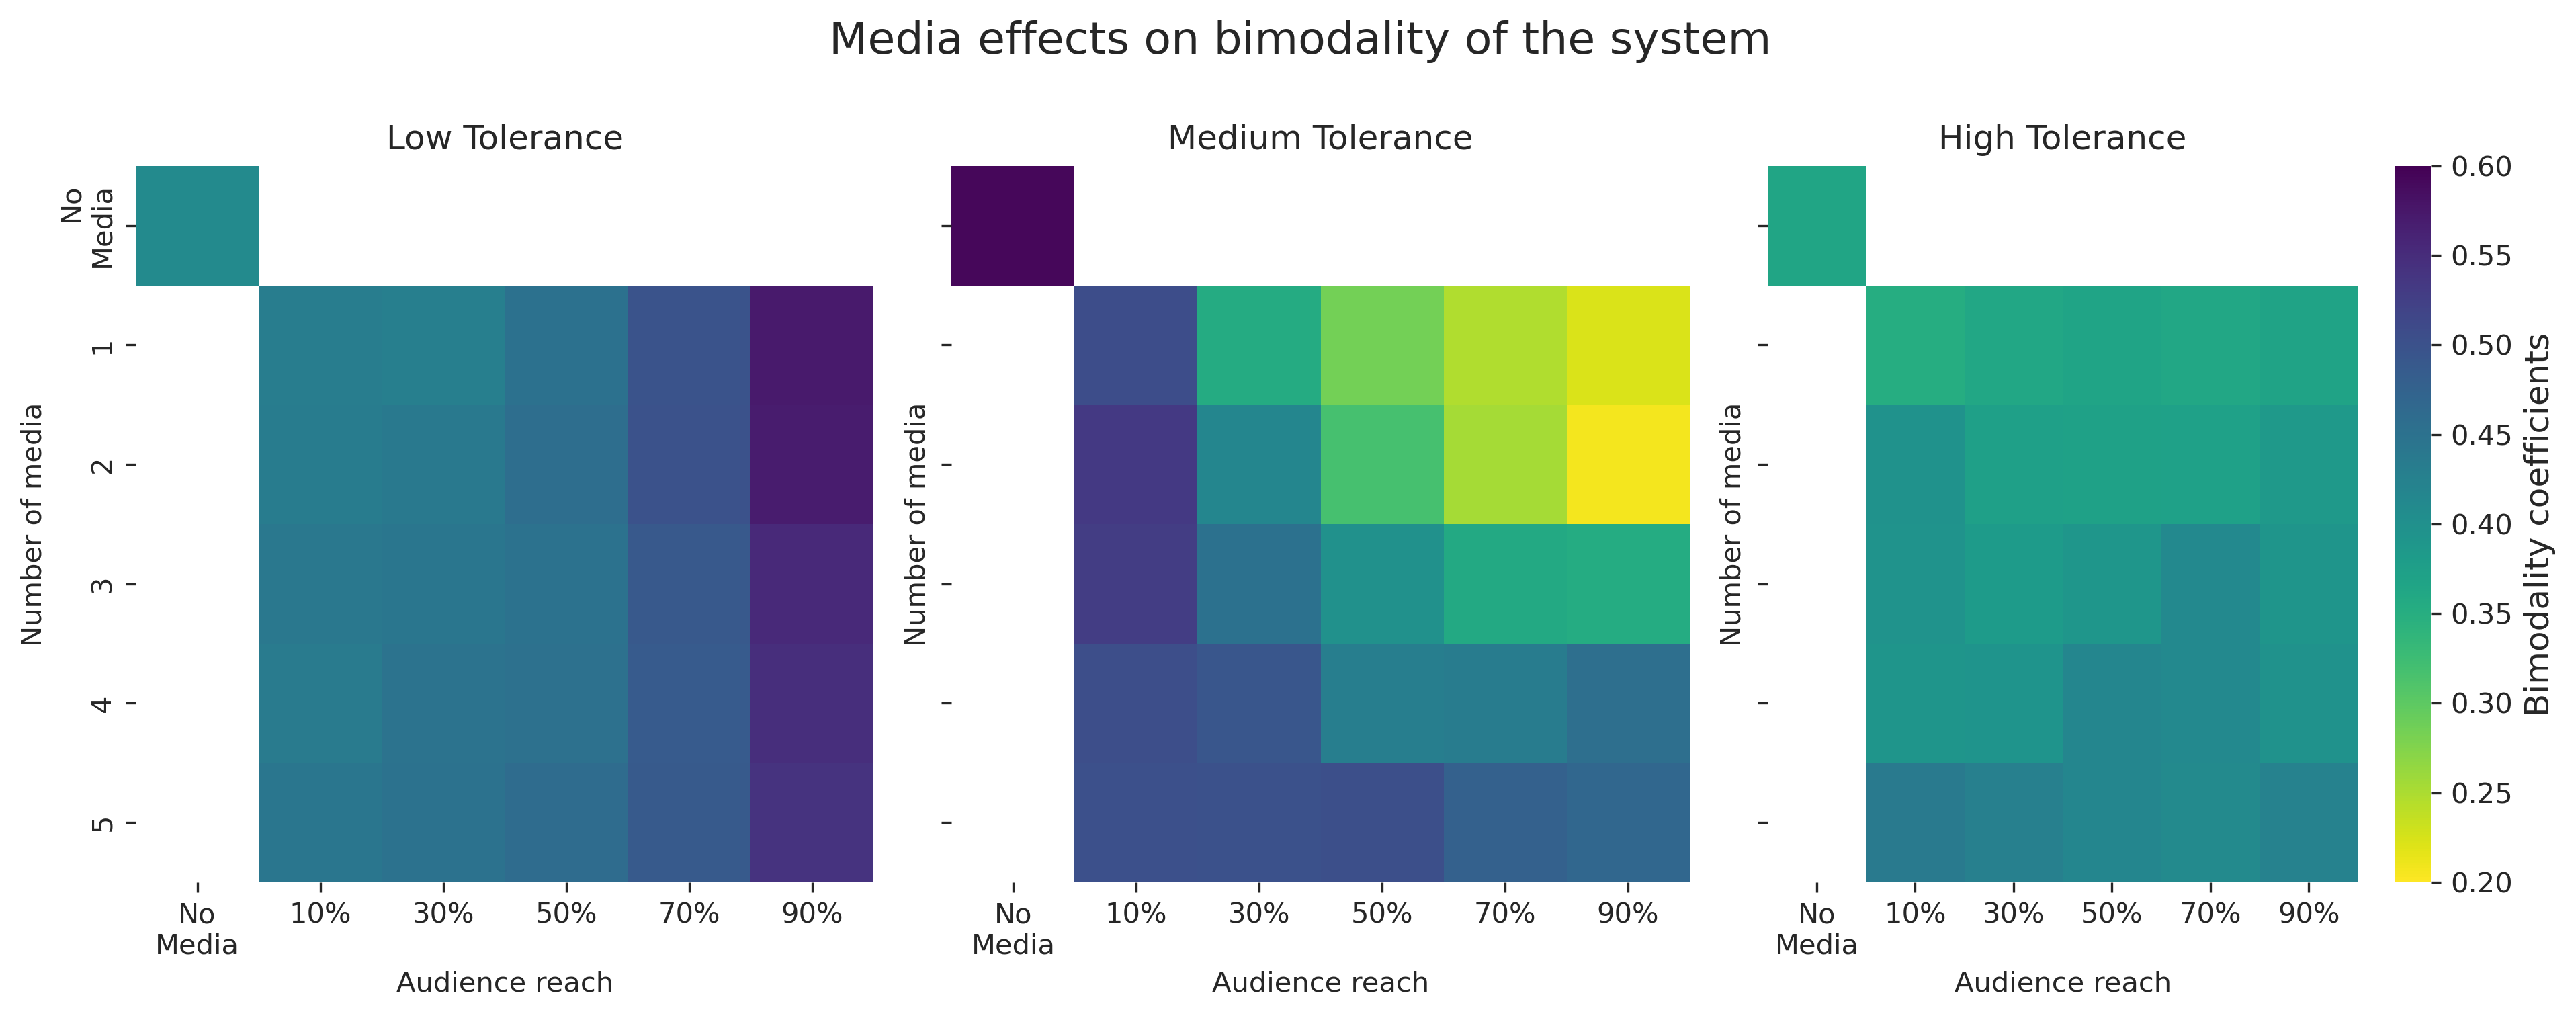

In [29]:
titles = ["Low Tolerance", "Medium Tolerance", "High Tolerance"]
fig, axes = plt.subplots(1, 3, figsize = (13,5), dpi = 300, sharey = True, sharex = True)
for i, ax in enumerate(axes):
    heatmap = sns.heatmap(ave_bc[etas[i]], ax = ax, cmap = "viridis_r", cbar_kws={"orientation": "vertical", "location": "right"}, vmin = .2, vmax = .6)
    cbar = heatmap.collections[0].colorbar
    if i !=2:
        cbar.remove()
    else:
        cbar.ax.set_ylabel("Bimodality coefficients", fontsize = 12)
    ax.set_ylabel("Number of media")
    ax.set_xlabel("Audience reach")
    ax.set_title(titles[i])
    ax.set_xticklabels(["No\nMedia"]+[str(i*10) + "%" for i in [1,3,5,7,9 ]])
    ax.set_yticklabels(["No\nMedia"]+[1, 2, 3, 4, 5])

plt.suptitle("Media effects on bimodality of the system", fontsize = 16, y = 1.0)
plt.tight_layout()

In [49]:
def gmm_optimal_cluster(data, max_clusters=10):
    """
    Find the optimal number of clusters using Gaussian mixture modeling.
    
    Parameters:
    data (numpy array): data set to be clustered
    max_clusters (int): maximum number of clusters to consider
    
    Returns:
    optimal_clusters (int): the optimal number of clusters
    """
    
    # Initialize the BIC score and number of clusters
    min_bic = np.inf
    optimal_clusters = None
    x = data.values.reshape(-1,1)
    # Loop over the number of clusters and fit a GMM to the data
    for k in range(1, max_clusters+1):
        GMM = gmm(n_components=k, random_state=0).fit(x)
        
        # Calculate the BIC score and update the optimal number of clusters if necessary
        bic = GMM.bic(x)
        if bic < min_bic:
            min_bic = bic
            optimal_clusters = k
        #else:
            #break
    membership= pd.DataFrame(GMM.predict(x))
    return optimal_clusters, membership

In [50]:
gmm_n = {}
gmm_mb = {}
for f in tqdm(op_files):
    df = pd.read_parquet(OP_DIR+f"/{f}")
    oc = []
    mbs = []
    for c in df.columns:
        n, mb = gmm_optimal_cluster(df[c])
        oc.append(n)
        mbs.append(mb)
    gmm_n[tuple(f.split("_")[:2])] = {"cluster":oc }
    gmm_mb[tuple(f.split("_")[:2])] = {"cluster":mbs}

100%|██████████| 78/78 [18:22<00:00, 14.13s/it]


In [51]:
communities = pd.concat([ pd.DataFrame(v).cluster for v in gmm_n.values()], axis = 1, ignore_index= True)
communities.columns = gmm_n.keys()
communities = communities.T.reset_index()
communities["N"] = communities.level_0.apply(lambda x: int(x[-1]))
communities["s"] = communities.level_1.apply(lambda x: int(x[1]))
communities["eta"] = communities.level_1.apply(lambda x: int(x[-1]))

In [53]:
communities.to_csv("communities_max.csv")

In [54]:
ave_cm = {}
etas = [2, 5, 8]
for eta in etas:
    ave_cm_one = communities[communities.eta ==eta].groupby(["N", "s"])[list(range(100))].mean().mean(axis =1).reset_index()
    ave_cm[eta] =ave_ent_one.pivot (index = "N", columns = "s", values = 0)

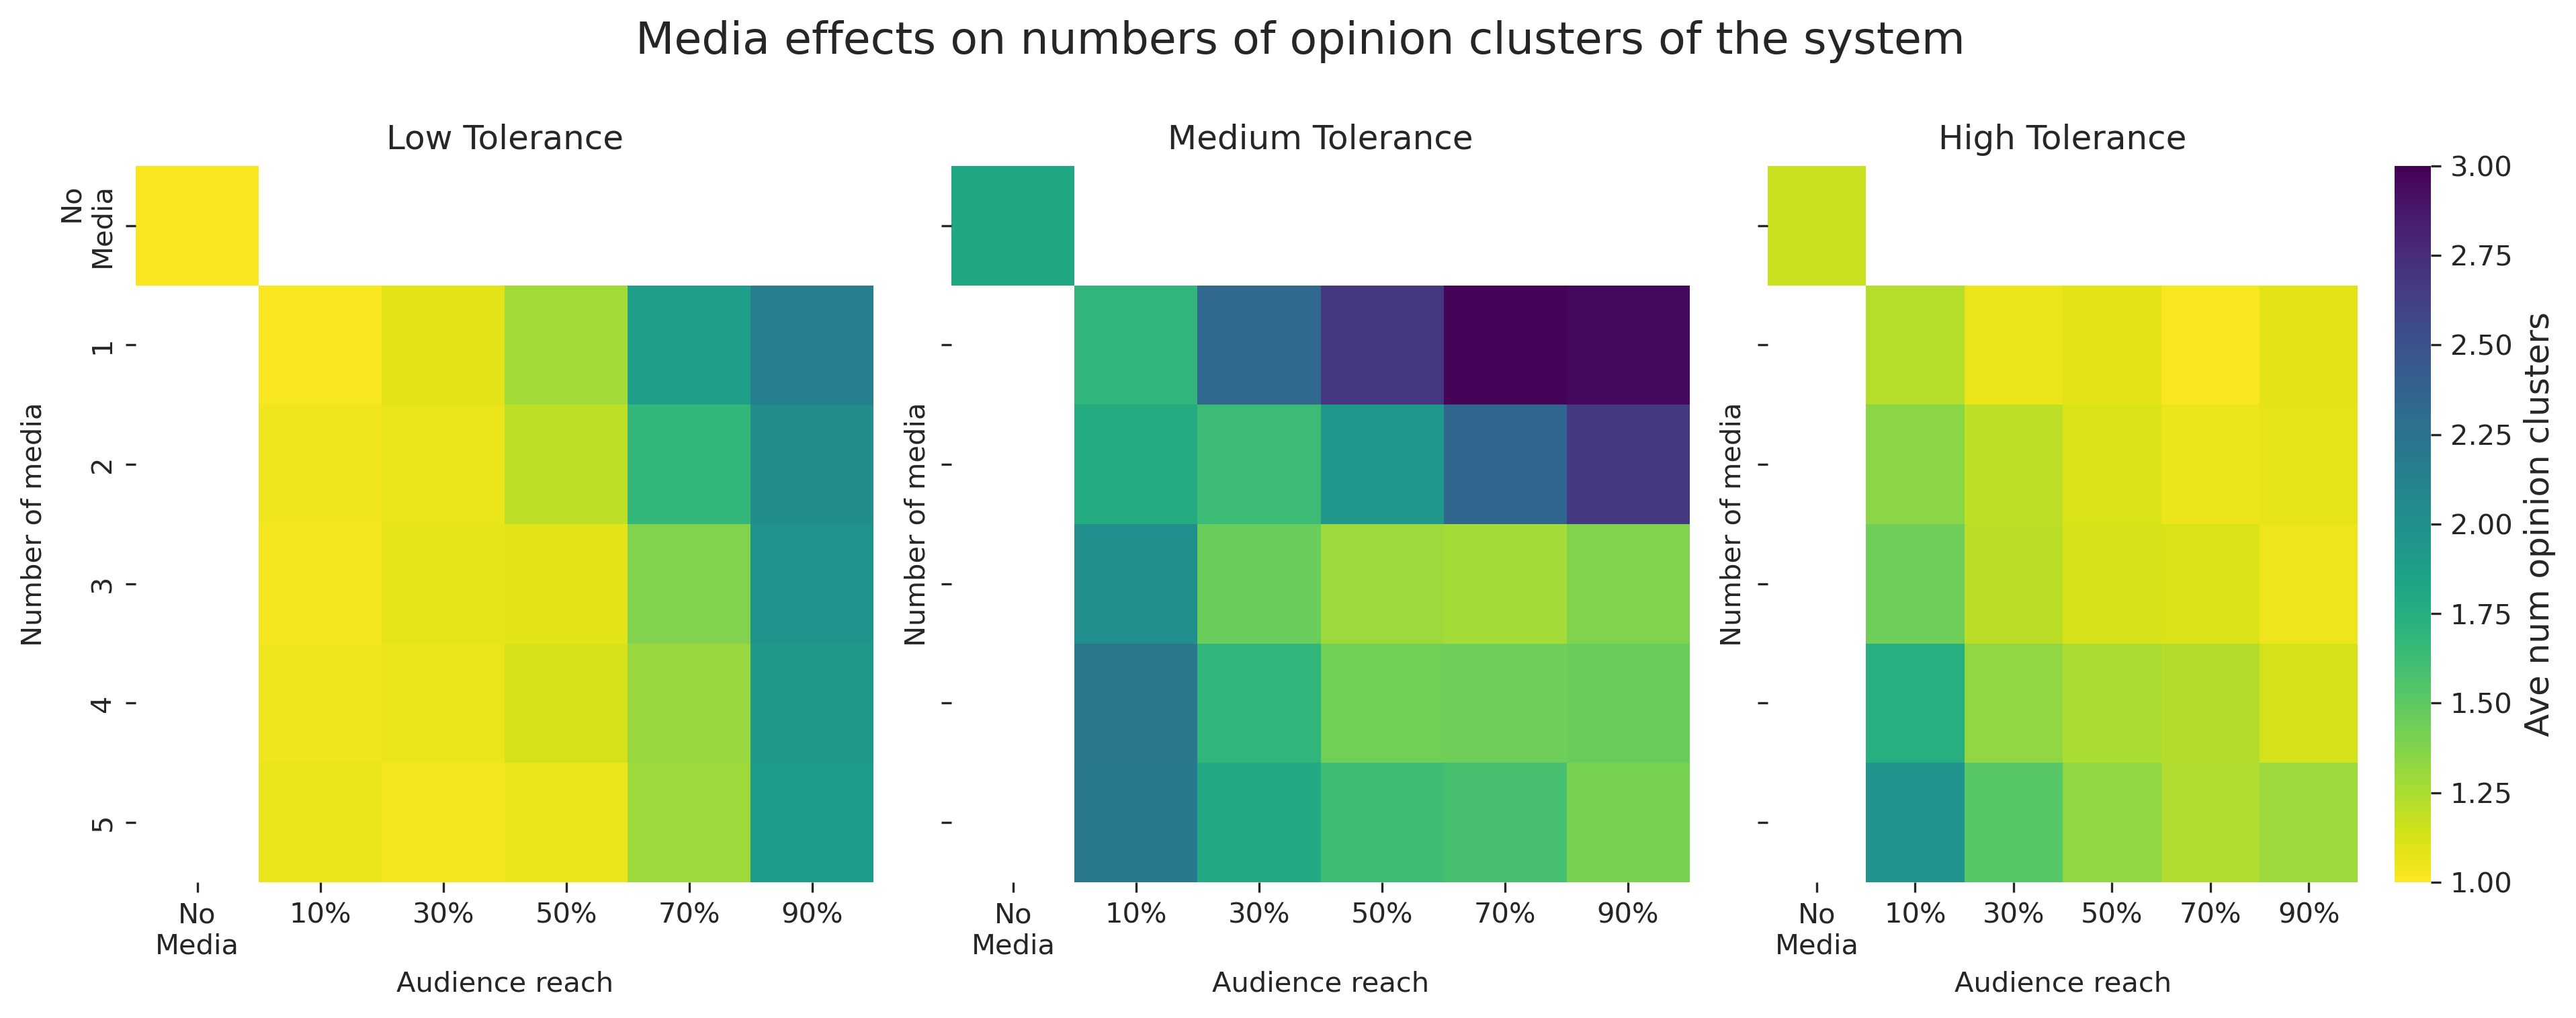

In [93]:
titles = ["Low Tolerance", "Medium Tolerance", "High Tolerance"]
fig, axes = plt.subplots(1, 3, figsize = (13,5), dpi = 300, sharey = True, sharex = True)
for i, ax in enumerate(axes):
    heatmap = sns.heatmap(ave_cm[etas[i]], ax = ax, cmap = "viridis_r", cbar_kws={"orientation": "vertical", "location": "right"}, vmin = 1, vmax = 3)
    cbar = heatmap.collections[0].colorbar
    if i !=2:
        cbar.remove()
    else:
        cbar.ax.set_ylabel("Ave num opinion clusters", fontsize = 12)
    ax.set_ylabel("Number of media")
    ax.set_xlabel("Audience reach")
    ax.set_title(titles[i])
    ax.set_xticklabels(["No\nMedia"]+[str(i*10) + "%" for i in [1,3,5,7,9 ]])
    ax.set_yticklabels(["No\nMedia"]+[1, 2, 3, 4, 5])

plt.suptitle("Media effects on numbers of opinion clusters of the system", fontsize = 16, y = 1.0)
plt.tight_layout()

In [17]:
bc_base_2 = base_eta2.apply(BC, axis = 0)
bc_base_5 = base_eta5.apply(BC, axis = 0)
bc_base_8 = base_eta8.apply(BC, axis = 0)

(array([ 2.,  8., 34., 31., 20.,  1.,  0.,  1.,  1.,  2.]),
 array([0.14587692, 0.21054397, 0.27521101, 0.33987806, 0.40454511,
        0.46921215, 0.5338792 , 0.59854625, 0.66321329, 0.72788034,
        0.79254738]),
 <BarContainer object of 10 artists>)

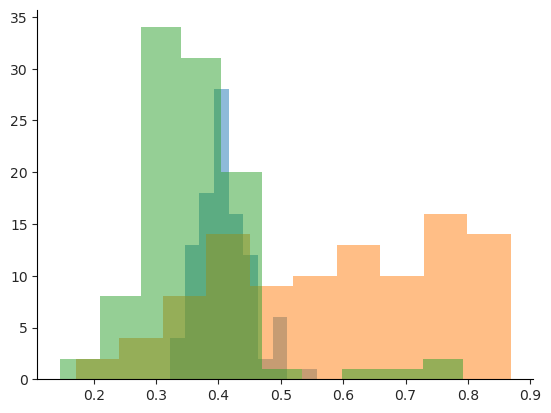

In [18]:
plt.hist(bc_base_2, alpha = .5)
plt.hist(bc_base_5, alpha = .5)
plt.hist(bc_base_8, alpha = .5)

In [122]:
me_folders = []
for n in Ns:
    n_f = ROOT_DIR+f"{n}/"
    folders = os.listdir(n_f)
    for f in folders:
        me_folders.append(f"{n}/{f}/effects/")

In [117]:
ms_folders = []
for n in Ns:
    n_f = ROOT_DIR+f"{n}/"
    folders = os.listdir(n_f)
    for f in folders:
        ms_folders.append(f"{n}/{f}/messages/")

In [123]:
test_dir = ROOT_DIR + me_folders[-1]
test_f= os.listdir(test_dir)[0]
test_effects = pd.read_parquet(test_dir + '/' + test_f)

In [120]:
test_dir = ROOT_DIR + ms_folders[-1]
test_f= os.listdir(test_dir)[0]
test_message = pd.read_parquet(test_dir + '/' + test_f)

In [126]:
test_effects

,uid,Time,index,effects
0,8,2,5,True
1,8,2,2,False
2,57,3,2,False
3,57,3,5,False
4,57,3,8,False
...,...,...,...,...
56670,24,9999,32053,True
56671,24,9999,32039,False
56672,24,9999,32048,False
56673,82,10000,32043,False


In [130]:
test_message.reset_index()

,index,original_poster,rt_poster,content,rt_status
0,0,m0,m0,0.062442,False
1,1,m4,m4,-0.601403,False
2,2,m3,m3,-0.077661,False
3,3,65,65,0.798522,False
4,4,m1,m1,-0.096958,False
...,...,...,...,...,...
32239,32239,m0,m0,-0.277321,False
32240,32240,m1,m1,0.397776,False
32241,32241,m3,m3,0.344948,False
32242,32242,m4,m4,-0.138030,False


In [134]:
pd.merge(test_message.reset_index(), test_effects, on = "index", how = "right")

,index,original_poster,rt_poster,content,rt_status,uid,Time,effects
0,5,m2,m2,0.035475,False,8,2,True
1,2,m3,m3,-0.077661,False,8,2,False
2,2,m3,m3,-0.077661,False,57,3,False
3,5,m2,m2,0.035475,False,57,3,False
4,8,m1,62,-0.096958,True,57,3,False
...,...,...,...,...,...,...,...,...
56670,32053,m2,4,0.056799,True,24,9999,True
56671,32039,m3,m3,-0.139465,False,24,9999,False
56672,32048,91,91,-0.285313,False,24,9999,False
56673,32043,m4,m4,0.448833,False,82,10000,False


In [115]:
me_folders[-1]

'N5/s9eta2/effects/'

In [139]:
data_folders = []
for n in Ns:
    n_f = ROOT_DIR+f"{n}/"
    folders = os.listdir(n_f)
    for f in folders:
        data_folders.append(f"{n_f}{f}")

In [ ]:
'/N/slate/harryan/sim_data/N1/s7eta8'

In [141]:
def indi_eff(folder):
    

['/N/slate/harryan/sim_data/N1/s7eta8',
 '/N/slate/harryan/sim_data/N1/s1eta8',
 '/N/slate/harryan/sim_data/N1/s3eta5',
 '/N/slate/harryan/sim_data/N1/s5eta2',
 '/N/slate/harryan/sim_data/N1/s3eta8',
 '/N/slate/harryan/sim_data/N1/s1eta5',
 '/N/slate/harryan/sim_data/N1/s1eta2',
 '/N/slate/harryan/sim_data/N1/s9eta8',
 '/N/slate/harryan/sim_data/N1/s9eta5',
 '/N/slate/harryan/sim_data/N1/s7eta5',
 '/N/slate/harryan/sim_data/N1/s5eta8',
 '/N/slate/harryan/sim_data/N1/s5eta5',
 '/N/slate/harryan/sim_data/N1/s7eta2',
 '/N/slate/harryan/sim_data/N1/s3eta2',
 '/N/slate/harryan/sim_data/N1/s9eta2',
 '/N/slate/harryan/sim_data/N2/s7eta8',
 '/N/slate/harryan/sim_data/N2/s1eta8',
 '/N/slate/harryan/sim_data/N2/s3eta5',
 '/N/slate/harryan/sim_data/N2/s5eta2',
 '/N/slate/harryan/sim_data/N2/s3eta8',
 '/N/slate/harryan/sim_data/N2/s1eta5',
 '/N/slate/harryan/sim_data/N2/s1eta2',
 '/N/slate/harryan/sim_data/N2/s9eta8',
 '/N/slate/harryan/sim_data/N2/s9eta5',
 '/N/slate/harryan/sim_data/N2/s7eta5',
